📈 Analisi Quantitativa e Backtasting su S&P 500: Strategia di Trading Weekend-Based📈

Ciao,sono Gianluca Semprebuono, studente magistrale in Financial Risk and Data Analysis presso La Sapienza, Università di Roma.

Voglio condividere con voi un progetto in Python che sto sviluppando, focalizzato sull'analisi quantitativa applicata allo S&P 500.

Il codice implementa una strategia di trading strutturata in più fasi, che combinano analisi tecnica, analisi degli scenari di gap tra venerdì e lunedì, conferma pre-market e simulazione/backtest con gestione dinamica del rischio e ottimizzazione dei parametri. Di seguito viene spiegata esaustivamente la logica e il flusso della strategia:

---

## 1. Acquisizione dei Dati e Calcolo degli Indicatori Tecnici

**Scaricamento dei dati**  
- La funzione `download_data` utilizza la libreria **yfinance** per scaricare i dati giornalieri (prezzo di apertura, chiusura, massimo, minimo, volume) per un dato ticker (in questo esempio lo S&P500 con ticker `^GSPC`) tra due date specificate.

**Calcolo degli Indicatori**  
- **Medie Mobili (SMA):**  
  - *SMA_10* e *SMA_50* sono calcolate come la media mobile semplice dei prezzi di chiusura su finestre di 10 e 50 giorni, utili per identificare trend a breve e medio termine.
- **RSI (Relative Strength Index):**  
  - Calcolato su 14 periodi, misura la forza e la velocità delle variazioni dei prezzi, evidenziando condizioni di ipercomprato o ipervenduto.
- **MACD e Signal Line:**  
  - Il MACD è la differenza tra l’EMA a 12 e 26 periodi, mentre la linea di segnale è una media esponenziale (9 periodi) del MACD, utile per individuare segnali di inversione.
- **Bollinger Bands:**  
  - La banda centrale è la SMA a 20 giorni; le bande superiore e inferiore si ottengono aggiungendo e sottraendo due volte la deviazione standard, per valutare la volatilità.
- **ROC (Rate of Change):**  
  - Misura la variazione percentuale dei prezzi su 12 periodi.
- **OBV (On Balance Volume):**  
  - Un indicatore che integra il volume con il movimento dei prezzi, accumulando il volume in base alla direzione del prezzo.
- **ATR (Average True Range):**  
  - Indica la volatilità media su 14 giorni, utilizzato poi per definire stop loss dinamici.

---

## 2. Creazione del Dataset Friday-Monday e Definizione degli Scenari

**Accoppiamento dei giorni**  
- La funzione `pair_friday_monday` crea dei **coppie** in cui per ogni lunedì viene associato il venerdì immediatamente precedente.  
- Per ciascuna coppia si registrano dati come:
  - Per lunedì: apertura, massimo, minimo, chiusura, volume.
  - Per venerdì: solo il prezzo di chiusura.

**Definizione degli Scenari**  
- Utilizzando la funzione `assign_scenario`, ogni coppia viene classificata in quattro scenari in base alla relazione tra il gap (differenza tra il venerdì e il lunedì) e l’andamento intraday del lunedì:
  - **Scenario 1 (Bullish):** Il prezzo di chiusura di venerdì è inferiore all’apertura di lunedì e il lunedì chiude in rialzo (close > open).
  - **Scenario 2 (Bearish):** Venerdì chiude sotto l’apertura di lunedì, ma il lunedì chiude in ribasso.
  - **Scenario 3 (Bullish):** Venerdì chiude sopra l’apertura di lunedì e il lunedì è rialzista.
  - **Scenario 4 (Bearish):** Venerdì chiude sopra l’apertura di lunedì e il lunedì è ribassista.
- Inoltre, viene previsto un filtro per escludere coppie in cui sono presenti eventi macroeconomici ad alto impatto (utilizzando un placeholder per l’integrazione con un calendario economico).

---

## 3. Integrazione degli Indicatori Tecnici e Regressione

**Merge dei Dati**  
- La funzione `merge_indicators_to_pairs` unisce i dati delle coppie Friday-Monday con gli indicatori tecnici, associando ad ogni lunedì i valori degli indicatori calcolati in precedenza.

**Modello di Regressione**  
- Con `perform_regression`, viene creata una variabile target binaria “Success” (1 se il lunedì chiude in rialzo, 0 altrimenti).
- Viene usata una **regressione lineare** con indicatori selezionati (SMA_10, SMA_50, RSI, MACD, MACD_Signal, ROC, OBV) per valutare la relazione tra gli indicatori e il successo del trade.
- Il modello genera un **Indicator_Score** che viene poi normalizzato su una scala 0-1, fornendo un punteggio che rappresenta la “forza” predittiva degli indicatori per il trade.

---

## 4. Analisi del Pre-Market e Calcolo della Trade_Probability

**Analisi Pre-Market**  
- La funzione `analyze_pre_market` scarica dati a intervalli di 1 minuto per il pre-market (8:00-9:30 AM EST) per ogni lunedì, analizzando:
  - Il volume totale nel pre-market.
  - La tendenza (bullish se il prezzo di chiusura supera l’apertura, bearish se è il contrario, neutral in caso di parità).

**Calcolo della Trade_Probability**  
- La funzione `compute_trade_probability` combina:
  - Il punteggio normalizzato degli indicatori (Indicator_Score_Norm).
  - La frequenza degli scenari (cioè quanto spesso si verifica un dato scenario nella storia, utile come proxy probabilistica).
- Se sono disponibili dati pre-market e il volume supera una soglia, il punteggio viene corretto:
  - Viene **aumentato** (fattore di conferma) se il trend pre-market conferma l’aspettativa dello scenario.
  - Viene **ridotto** (fattore di contraddizione) se il trend non è in linea con l’aspettativa.

---

## 5. Simulazione della Strategia: Backtesting, Equity Curve e Gestione del Rischio

**Simulazione dei Trade**  
- Le funzioni `backtest_strategy_dynamic`, `simulate_equity_curve_dynamic` e `simulate_trades_details_dynamic` simulano l’esecuzione dei trade in base a una soglia minima di Trade_Probability.
- Il calcolo del rendimento del trade include:
  - **Take Profit (TP)** e **Stop Loss (SL):**  
    - Se il rendimento lordo supera il TP o scende sotto il livello di SL, viene fissato il profitto o la perdita.
  - **Stop Loss Dinamico:**  
    - Se attivato, utilizza il valore dell’ATR (volatilità) per adattare dinamicamente il livello di SL.
  - **Allocazione Dinamica del Capitale:**  
    - La percentuale di capitale investita può variare in base alla Trade_Probability, aumentando l’esposizione in presenza di segnali più forti.
  - **Leva Finanziaria:**  
    - Il calcolo del trade size include un fattore leva (es. 50x) per amplificare i guadagni o le perdite.
- Durante la simulazione vengono inoltre calcolati metriche di performance come:
  - **Final Capital, Profitto Totale, Percentuale di Successo.**
  - **Max Drawdown:** La massima perdita dal picco di equity.
  - **Sharpe Ratio:** Basato sui log return per valutare il rapporto rischio/rendimento.

---

## 6. Ottimizzazione dei Parametri: Grid Search e Bayesian Optimization

**Grid Search**  
- Viene eseguita una ricerca esaustiva su una griglia di parametri (percentuale di investimento, TP e SL) per identificare la combinazione che massimizza il capitale finale nel backtest.
- I risultati della grid search forniscono una “strategia migliore” in termini di performance storica.

**Ottimizzazione Bayesiana**  
- Utilizzando la libreria **bayes_opt**, viene definita una funzione obiettivo che esegue il backtest e restituisce il capitale finale.
- I parametri ottimizzati (invest_pct, TP, SL) vengono ricercati in modo più efficiente rispetto al grid search, monitorando anche la convergenza attraverso un grafico.

---

## 7. Esecuzione e Output Finali

**Flusso Principale**  
- Il blocco `if __name__ == "__main__":` coordina l’intero processo:
  1. **Scaricamento e Preparazione:** Dati storici e indicatori tecnici vengono scaricati e calcolati.
  2. **Dataset Friday-Monday:** Vengono accoppiati i dati di venerdì e lunedì, classificati per scenario e filtrati per eventi macroeconomici.
  3. **Integrazione e Regressione:** Gli indicatori vengono uniti ai dati dei trade e la regressione lineare produce il punteggio predittivo.
  4. **Analisi Pre-Market e Calcolo Trade_Probability:** Si integra l’analisi del pre-market per confermare o smentire la validità dello scenario.
  5. **Backtest e Simulazione:** Vengono simulati i trade con gestione dinamica del rischio e visualizzata l’equity curve.
  6. **Ottimizzazione:** Sia il grid search che l’ottimizzazione bayesiana vengono utilizzati per affinare i parametri della strategia.
  7. **Output Finali:** Vengono stampate statistiche, salvati file CSV con i dettagli dei trade e tracciati grafici dell’equity curve e della convergenza dell’ottimizzazione.

---

## Riassunto della Strategia

1. **Analisi Tecnica e Gap Weekend:**  
   - Vengono sfruttati indicatori tecnici (SMA, RSI, MACD, Bollinger Bands, ROC, OBV, ATR) per valutare trend e volatilità.
   - La logica si concentra sui gap tra il venerdì e il lunedì, classificando gli scenari in base alla direzione del gap e al comportamento intraday del lunedì.

2. **Modello Predittivo:**  
   - Una regressione lineare stima la probabilità di successo (trade vincente) basandosi sui valori degli indicatori tecnici, creando un punteggio normalizzato (Indicator_Score_Norm).

3. **Conferma Pre-Market:**  
   - L’analisi del pre-market integra un ulteriore livello di conferma, correggendo il punteggio se il trend pre-market è in linea (o contrario) con lo scenario atteso.

4. **Gestione Dinamica del Rischio e Allocazione:**  
   - La strategia adotta stop loss dinamici basati sull’ATR e un’allocazione variabile del capitale in funzione della forza del segnale, con leva finanziaria per amplificare gli effetti.

5. **Ottimizzazione e Backtesting:**  
   - Tramite grid search e ottimizzazione bayesiana vengono testati e affinati i parametri chiave (percentuale d’investimento, TP, SL) per massimizzare le performance storiche, monitorando metriche come il capitale finale, il max drawdown e lo Sharpe Ratio.


In [1]:
!pip install bayesian-optimization


Scaricando dati...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
<ipython-input-2-1d659a7cf288>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  close_current = float(df['Close'].iloc[i])
<ipython-input-2-1d659a7cf288>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  close_prev = float(df['Close'].iloc[i-1])
<ipython-input-2-1d659a7cf288>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vol_current = float(df['Volume'].iloc[i])


Frequenze degli scenari:
Scenario
1    16
2    15
3     9
4     8
Name: count, dtype: int64

Il miglior scenario da investire è lo scenario 1 con frequenza 33.33%

Coefficienti della regressione (ponderazione degli indicatori):
SMA_10: -0.0073
SMA_50: 0.0052
RSI: -0.0068
MACD: -0.0000
MACD_Signal: 0.0197
ROC: 0.0596
OBV: 0.0000


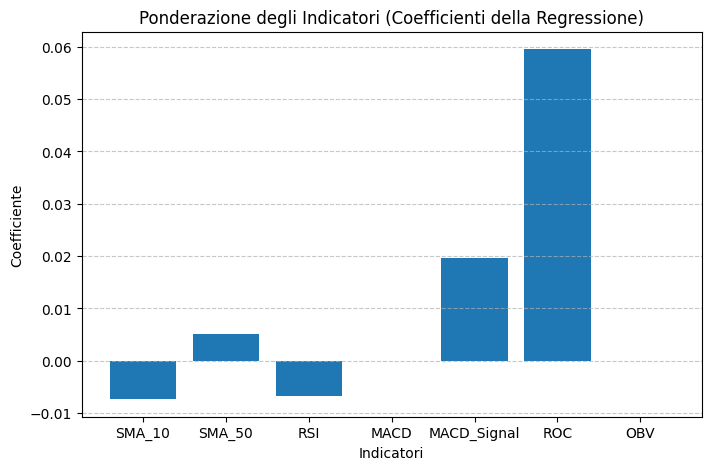

[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: ValueError('unconverted data remains:  09:30:00')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: ValueError('unconverted data remains:  09:30:00')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: ValueError('unconverted data remains:  09:30:00')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: ValueError('unconverted data remains:  09:30:00')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^GSPC']: ValueError('unconverted data remains:  09:30:00')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed downlo

Testate 50/3360 combinazioni...
Testate 100/3360 combinazioni...
Testate 150/3360 combinazioni...
Testate 200/3360 combinazioni...
Testate 250/3360 combinazioni...
Testate 300/3360 combinazioni...
Testate 350/3360 combinazioni...
Testate 400/3360 combinazioni...
Testate 450/3360 combinazioni...
Testate 500/3360 combinazioni...
Testate 550/3360 combinazioni...
Testate 600/3360 combinazioni...
Testate 650/3360 combinazioni...
Testate 700/3360 combinazioni...
Testate 750/3360 combinazioni...
Testate 800/3360 combinazioni...
Testate 850/3360 combinazioni...
Testate 900/3360 combinazioni...
Testate 950/3360 combinazioni...
Testate 1000/3360 combinazioni...
Testate 1050/3360 combinazioni...
Testate 1100/3360 combinazioni...
Testate 1150/3360 combinazioni...
Testate 1200/3360 combinazioni...
Testate 1250/3360 combinazioni...
Testate 1300/3360 combinazioni...
Testate 1350/3360 combinazioni...
Testate 1400/3360 combinazioni...
Testate 1450/3360 combinazioni...
Testate 1500/3360 combinazioni...


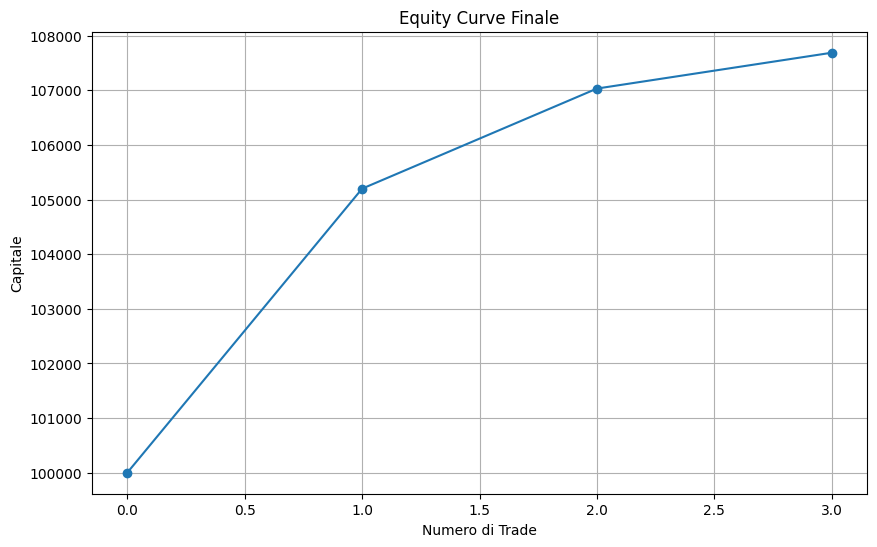


Inizio dell'ottimizzazione bayesiana...
|   iter    |  target   |    SL     |    TP     | invest... |
-------------------------------------------------------------
| 1         | 1.058e+05 | 2.124     | 5.803     | 0.07588   |
| 2         | 1.018e+05 | 2.796     | 2.624     | 0.02404   |
| 3         | 1.049e+05 | 1.174     | 5.465     | 0.0641    |
| 4         | 1.075e+05 | 3.124     | 2.082     | 0.09729   |
| 5         | 1.02e+05  | 3.497     | 2.849     | 0.02636   |
| 6         | 1.044e+05 | 1.55      | 3.217     | 0.05723   |
| 7         | 1.05e+05  | 2.296     | 3.165     | 0.06507   |
| 8         | 1.033e+05 | 1.418     | 3.169     | 0.04297   |
| 9         | 1.021e+05 | 2.368     | 5.141     | 0.02797   |
| 10        | 1.011e+05 | 2.543     | 4.37      | 0.01418   |
| 11        | 1.076e+05 | 3.914     | 4.53      | 0.09873   |
| 12        | 1.013e+05 | 1.482     | 3.596     | 0.01779   |
| 13        | 1.017e+05 | 1.976     | 3.916     | 0.02285   |
| 14        | 1.054e+05 | 3.9

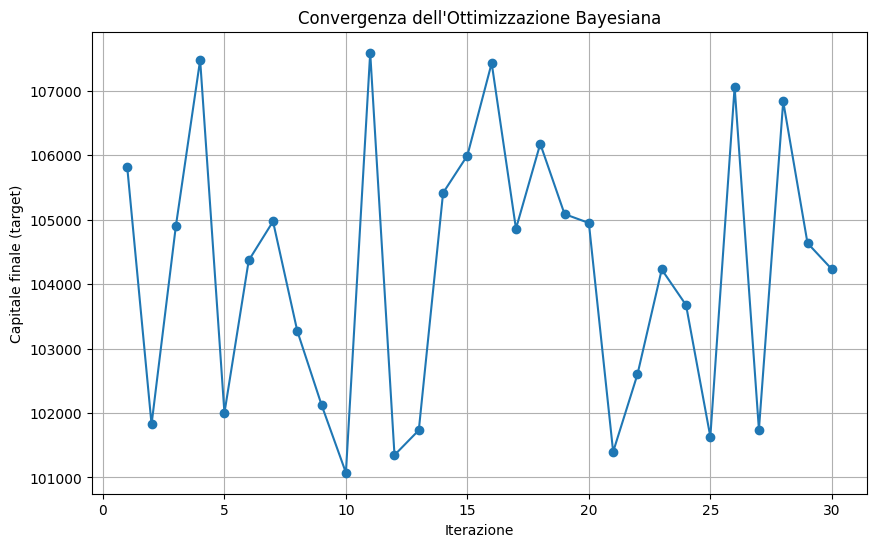


Spiegazione della strategia:
1. Abbiamo scaricato i dati dello S&P500 e calcolato numerosi indicatori tecnici per valutare trend e volatilità.
2. Abbiamo creato un dataset che accoppia i dati del venerdì e del lunedì, escludendo i giorni con eventi macroeconomici ad alto impatto.
3. Una regressione lineare ha analizzato la relazione tra gli indicatori e il successo del trade, ottenendo coefficienti che ponderano ciascun indicatore:
   SMA_10: -0.0073
   SMA_50: 0.0052
   RSI: -0.0068
   MACD: -0.0000
   MACD_Signal: 0.0197
   ROC: 0.0596
   OBV: 0.0000
4. Il pre-market (8:00-9:30 AM EST) viene analizzato per confermare o smentire lo scenario di trading basato sul gap lunedì.
5. La Trade_Probability viene calcolata combinando lo score normalizzato, la frequenza degli scenari e l'analisi pre-market.
6. Il backtest simula la strategia con stop loss dinamico (basato sull'ATR) e allocazione dinamica del capitale.
7. L'ottimizzazione bayesiana ha ulteriormente affinato i parametri ottimali.

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import random
from sklearn.linear_model import LinearRegression
from bayes_opt import BayesianOptimization
# Per integrare un calendario economico si potrebbe usare la libreria "requests"
import requests



#################################################################
# FASE 1: Scaricare i dati e calcolare gli indicatori tecnici   #
#################################################################
def download_data(ticker, start, end):
    """
    Scarica i dati giornalieri per il ticker specificato.
    """
    print("Scaricando dati...")
    df = yf.download(ticker, start=start.strftime('%Y-%m-%d'),
                     end=end.strftime('%Y-%m-%d'), interval='1d')
    df.reset_index(inplace=True)
    return df

def compute_technical_indicators(df):
    """
    Calcola indicatori: SMA_10, SMA_50, RSI (14), MACD (12,26,9), Bollinger Bands (20),
    ROC (12), OBV e ATR (14).
    """
    df = df.copy()

    # Medie mobili
    df['SMA_10'] = df['Close'].rolling(window=10).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()

    # RSI (14 periodi)
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # MACD e MACD_Signal (12,26,9)
    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema12 - ema26
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Bollinger Bands (20 periodi)
    df['BB_Middle'] = df['Close'].rolling(window=20).mean()
    df['BB_STD'] = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = df['BB_Middle'] + 2 * df['BB_STD']
    df['BB_Lower'] = df['BB_Middle'] - 2 * df['BB_STD']

    # ROC (12 periodi)
    df['ROC'] = df['Close'].pct_change(periods=12) * 100

    # OBV (On Balance Volume)
    obv = [0]
    for i in range(1, len(df)):
        close_current = float(df['Close'].iloc[i])
        close_prev = float(df['Close'].iloc[i-1])
        vol_current = float(df['Volume'].iloc[i])
        if close_current > close_prev:
            obv.append(obv[-1] + vol_current)
        elif close_current < close_prev:
            obv.append(obv[-1] - vol_current)
        else:
            obv.append(obv[-1])
    df['OBV'] = obv

    # ATR (14 periodi)
    high_low = df['High'] - df['Low']
    high_close = (df['High'] - df['Close'].shift()).abs()
    low_close = (df['Low'] - df['Close'].shift()).abs()
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    df['ATR'] = tr.rolling(window=14).mean()

    return df

#################################################################
# FASE 2: Creare il dataset Friday-Monday e definire gli scenari  #
#################################################################
def get_scalar(val):
    if isinstance(val, pd.Series):
        return val.iloc[0]
    return val

def pair_friday_monday(df):
    """
    Per ogni lunedì, trova il venerdì immediatamente precedente e crea un DataFrame.
    """
    df['Date'] = pd.to_datetime(df['Date'])
    df['Weekday'] = df['Date'].dt.weekday  # Lunedì=0, Venerdì=4
    df_friday = df[df['Weekday'] == 4].copy().reset_index(drop=True)
    df_monday = df[df['Weekday'] == 0].copy().reset_index(drop=True)

    pairs = []
    for _, monday_row in df_monday.iterrows():
        monday_date = get_scalar(monday_row['Date'])
        monday_open = get_scalar(monday_row['Open'])
        monday_high = get_scalar(monday_row['High'])
        monday_low = get_scalar(monday_row['Low'])
        monday_close = get_scalar(monday_row['Close'])
        monday_volume = get_scalar(monday_row['Volume'])

        friday_candidates = df_friday[df_friday['Date'] < monday_date]
        if not friday_candidates.empty:
            friday_row = friday_candidates.iloc[-1]
            friday_date = get_scalar(friday_row['Date'])
            friday_close = get_scalar(friday_row['Close'])
            pairs.append({
                'Monday_Date': monday_date,
                'Friday_Date': friday_date,
                'Monday_Open': monday_open,
                'Monday_High': monday_high,
                'Monday_Low': monday_low,
                'Monday_Close': monday_close,
                'Monday_Volume': monday_volume,
                'Friday_Close': friday_close
            })
    return pd.DataFrame(pairs)

def assign_scenario(row):
    """
    Assegna uno dei quattro scenari:
      - Scenario 1: friday_close < monday_open e monday_close > monday_open (bullish).
      - Scenario 2: friday_close < monday_open e monday_close < monday_open (bearish).
      - Scenario 3: friday_close > monday_open e monday_close > monday_open (bullish).
      - Scenario 4: friday_close > monday_open e monday_close < monday_open (bearish).
    """
    friday_close = float(row['Friday_Close'])
    monday_open  = float(row['Monday_Open'])
    monday_close = float(row['Monday_Close'])

    if friday_close < monday_open:
        if monday_close > monday_open:
            return 1
        else:
            return 2
    elif friday_close > monday_open:
        if monday_close > monday_open:
            return 3
        else:
            return 4
    else:
        return np.nan

def compute_scenarios(df_pairs):
    df_pairs['Scenario'] = df_pairs.apply(lambda row: assign_scenario(row), axis=1)
    return df_pairs

# Integrazione del Calendario Economico per escludere giorni con eventi ad alto impatto
def is_high_impact_event(date):
    """
    Placeholder per l'integrazione con un'API di Calendario Economico (es. Forex Factory o Investing.com).
    Qui si definisce una lista di date con eventi di "alto impatto" (tipicamente indicati in rosso).
    """
    high_impact_dates = [
        # Esempio: datetime(2023, 9, 15), datetime(2023, 10, 20)
    ]
    return date.date() in [d.date() for d in high_impact_dates]

def filter_high_impact_pairs(df_pairs):
    """
    Esclude dal dataset le coppie in cui il lunedì o il venerdì corrispondono a giorni con eventi ad alto impatto.
    """
    df_filtered = df_pairs[~df_pairs['Monday_Date'].apply(lambda d: is_high_impact_event(d)) &
                           ~df_pairs['Friday_Date'].apply(lambda d: is_high_impact_event(d))]
    return df_filtered

#################################################################
# FASE 3: Unire gli indicatori tecnici al dataset e applicare la regressione
#################################################################
def merge_indicators_to_pairs(df_pairs, df_daily):
    df_daily['Date'] = pd.to_datetime(df_daily['Date'])
    if isinstance(df_daily.columns, pd.MultiIndex):
        df_daily.columns = df_daily.columns.get_level_values(0)
    df_pairs = df_pairs.copy()
    df_pairs['Monday_Date'] = pd.to_datetime(df_pairs['Monday_Date'])
    indicators = df_daily[['Date', 'SMA_10', 'SMA_50', 'RSI', 'MACD', 'MACD_Signal',
                             'BB_Middle', 'BB_Upper', 'BB_Lower', 'ROC', 'OBV', 'ATR']]
    df_merged = pd.merge(df_pairs, indicators, left_on='Monday_Date', right_on='Date', how='left')
    df_merged.drop(columns=['Date'], inplace=True)
    return df_merged

def perform_regression(df):
    """
    Esegue una regressione lineare utilizzando indicatori tecnici per predire il successo del trade.
    """
    df = df.copy()
    df['Success'] = (df['Monday_Close'] > df['Monday_Open']).astype(int)
    features = ['SMA_10', 'SMA_50', 'RSI', 'MACD', 'MACD_Signal', 'ROC', 'OBV']
    df_reg = df.dropna(subset=features).reset_index(drop=True)
    X = df_reg[features]
    y = df_reg['Success']

    model = LinearRegression()
    model.fit(X, y)

    df_reg['Indicator_Score'] = model.predict(X)
    min_score = df_reg['Indicator_Score'].min()
    max_score = df_reg['Indicator_Score'].max()
    df_reg['Indicator_Score_Norm'] = (df_reg['Indicator_Score'] - min_score) / (max_score - min_score)

    return model, df_reg

def plot_regression_coefficients(model, features):
    coef = model.coef_
    plt.figure(figsize=(8,5))
    plt.bar(features, coef)
    plt.xlabel("Indicatori")
    plt.ylabel("Coefficiente")
    plt.title("Ponderazione degli Indicatori (Coefficienti della Regressione)")
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()

#################################################################
# FASE 4: Analisi del Pre-Market e calcolo della Trade_Probability
#################################################################
def analyze_pre_market(ticker, monday_date):
    """
    Analizza il pre-market (8:00 - 9:30 AM EST) per il lunedì specificato.
    Restituisce un dizionario con il volume totale e il trend (bullish/bearish/neutral).
    """
    start_dt = datetime(monday_date.year, monday_date.month, monday_date.day, 8, 0)
    end_dt = datetime(monday_date.year, monday_date.month, monday_date.day, 9, 30)
    start_str = start_dt.strftime("%Y-%m-%d %H:%M:%S")
    end_str = end_dt.strftime("%Y-%m-%d %H:%M:%S")
    try:
        data = yf.download(ticker, start=start_str, end=end_str, interval="1m", prepost=True)
    except Exception as e:
        print(f"Errore nel download del pre-market: {e}")
        return None
    if data.empty:
        return None
    pre_market_volume = data['Volume'].sum()
    open_price = data['Open'].iloc[0]
    close_price = data['Close'].iloc[-1]
    if close_price > open_price:
        trend = "bullish"
    elif close_price < open_price:
        trend = "bearish"
    else:
        trend = "neutral"
    return {"pre_market_volume": pre_market_volume, "pre_market_trend": trend}

def add_pre_market_info(df, ticker):
    """
    Per ogni trade (lunedì) aggiunge le informazioni del pre-market.
    """
    pre_market_volumes = []
    pre_market_trends = []
    for idx, row in df.iterrows():
        monday_date = row['Monday_Date']
        pre_info = analyze_pre_market(ticker, monday_date)
        if pre_info is not None:
            pre_market_volumes.append(pre_info["pre_market_volume"])
            pre_market_trends.append(pre_info["pre_market_trend"])
        else:
            pre_market_volumes.append(np.nan)
            pre_market_trends.append(np.nan)
    df['PreMarket_Volume'] = pre_market_volumes
    df['PreMarket_Trend'] = pre_market_trends
    return df

def compute_trade_probability(row, scenario_stats, weight_scenario=0.5,
                              pre_market_volume_threshold=100000, confirm_factor=1.1, contradict_factor=0.7):
    """
    Calcola la Trade_Probability combinando l'indicator score normalizzato e la frequenza dello scenario.
    Se sono disponibili i dati del pre-market e il volume supera la soglia,
    il punteggio viene aumentato se il trend pre-market conferma lo scenario atteso o ridotto in caso contrario.
    """
    indicator_score = row['Indicator_Score_Norm']
    scenario = row['Scenario']
    if pd.isna(scenario):
        base_score = indicator_score
    else:
        scenario_prob = scenario_stats.get(scenario, 0)
        base_score = weight_scenario * scenario_prob + (1 - weight_scenario) * indicator_score

    # Integrazione dei dati pre-market
    pre_market_volume = row.get('PreMarket_Volume', np.nan)
    pre_market_trend = row.get('PreMarket_Trend', None)
    expected_trend = None
    if scenario in [1, 3]:
        expected_trend = "bullish"
    elif scenario in [2, 4]:
        expected_trend = "bearish"

    if not pd.isna(pre_market_volume) and pre_market_volume >= pre_market_volume_threshold and pre_market_trend is not None:
        if pre_market_trend == expected_trend:
            base_score *= confirm_factor
        else:
            base_score *= contradict_factor

    base_score = min(max(base_score, 0), 1)
    return base_score

def backtest_strategy_dynamic(df, base_invest_pct, TP, SL, trade_threshold=0.5, leverage=50, initial_capital=100000,
                              use_dynamic_sl=False, sl_multiplier=1.5, use_dynamic_allocation=False, allocation_multiplier=1.0):
    capital = initial_capital
    num_trades = 0
    wins = 0
    losses = 0
    profit_list = []

    for _, row in df.iterrows():
        if row['Trade_Probability'] >= trade_threshold:
            if use_dynamic_allocation:
                dynamic_invest_pct = base_invest_pct * (1 + allocation_multiplier * (row['Trade_Probability'] - trade_threshold))
                invest_pct = dynamic_invest_pct
            else:
                invest_pct = base_invest_pct

            num_trades += 1
            entry_price = row['Monday_Open']
            exit_price = row['Monday_Close']
            raw_return = (exit_price - entry_price) / entry_price

            if use_dynamic_sl:
                atr_value = row.get('ATR', np.nan)
                if pd.isna(atr_value):
                    effective_sl = SL
                else:
                    effective_sl = sl_multiplier * (atr_value / entry_price) * 100
            else:
                effective_sl = SL

            if raw_return >= TP/100:
                trade_return = TP/100
            elif raw_return <= -effective_sl/100:
                trade_return = -effective_sl/100
            else:
                trade_return = raw_return

            trade_size = invest_pct * capital * leverage
            profit = trade_size * trade_return
            capital += profit
            profit_list.append(profit)
            if trade_return > 0:
                wins += 1
            elif trade_return < 0:
                losses += 1

    success_pct = (wins / num_trades * 100) if num_trades > 0 else 0
    avg_win = np.mean([p for p in profit_list if p > 0]) if any(p > 0 for p in profit_list) else 0
    avg_loss = -np.mean([p for p in profit_list if p < 0]) if any(p < 0 for p in profit_list) else 0
    risk_reward_ratio = (avg_win / avg_loss) if avg_loss > 0 else np.nan

    return {
        'final_capital': capital,
        'total_profit': capital - initial_capital,
        'num_trades': num_trades,
        'wins': wins,
        'losses': losses,
        'success_pct': success_pct,
        'risk_reward_ratio': risk_reward_ratio,
        'base_invest_pct': base_invest_pct,
        'TP': TP,
        'SL': SL,
        'use_dynamic_sl': use_dynamic_sl,
        'use_dynamic_allocation': use_dynamic_allocation
    }

def optimize_parameters_dynamic(df, invest_pct_list, TP_range, SL_range, trade_threshold=0.5, leverage=50, initial_capital=100000,
                                  use_dynamic_sl=False, sl_multiplier=1.5, use_dynamic_allocation=False, allocation_multiplier=1.0):
    results = []
    total_combinations = len(invest_pct_list) * len(TP_range) * len(SL_range)
    combo_count = 0
    for base_invest_pct in invest_pct_list:
        for TP in TP_range:
            for SL in SL_range:
                combo_count += 1
                stats = backtest_strategy_dynamic(
                    df, base_invest_pct, TP, SL, trade_threshold, leverage, initial_capital,
                    use_dynamic_sl, sl_multiplier, use_dynamic_allocation, allocation_multiplier
                )
                results.append(stats)
                if combo_count % 50 == 0:
                    print(f"Testate {combo_count}/{total_combinations} combinazioni...")
    results_df = pd.DataFrame(results)
    best_strategy = results_df.loc[results_df['final_capital'].idxmax()]
    return best_strategy, results_df

#################################################################
# FASE 5: Simulare Equity Curve e Dettagli dei Trade               #
#################################################################
def simulate_equity_curve_dynamic(df, base_invest_pct, TP, SL, trade_threshold=0.5, leverage=50, initial_capital=100000,
                                  use_dynamic_sl=False, sl_multiplier=1.5, use_dynamic_allocation=False, allocation_multiplier=1.0):
    capital = initial_capital
    equity_curve = [capital]

    for _, row in df.iterrows():
        if row['Trade_Probability'] >= trade_threshold:
            if use_dynamic_allocation:
                dynamic_invest_pct = base_invest_pct * (1 + allocation_multiplier * (row['Trade_Probability'] - trade_threshold))
                invest_pct = dynamic_invest_pct
            else:
                invest_pct = base_invest_pct

            entry_price = row['Monday_Open']
            exit_price = row['Monday_Close']
            raw_return = (exit_price - entry_price) / entry_price

            if use_dynamic_sl:
                atr_value = row.get('ATR', np.nan)
                if pd.isna(atr_value):
                    effective_sl = SL
                else:
                    effective_sl = sl_multiplier * (atr_value / entry_price) * 100
            else:
                effective_sl = SL

            if raw_return >= TP/100:
                trade_return = TP/100
            elif raw_return <= -effective_sl/100:
                trade_return = -effective_sl/100
            else:
                trade_return = raw_return

            trade_size = invest_pct * capital * leverage
            profit = trade_size * trade_return
            capital += profit
            equity_curve.append(capital)

    return equity_curve

def simulate_trades_details_dynamic(df, base_invest_pct, TP, SL, trade_threshold=0.5, leverage=50, initial_capital=100000,
                                      use_dynamic_sl=False, sl_multiplier=1.5, use_dynamic_allocation=False, allocation_multiplier=1.0):
    capital = initial_capital
    trades = []
    trade_number = 0
    for idx, row in df.iterrows():
        if row['Trade_Probability'] >= trade_threshold:
            trade_number += 1
            if use_dynamic_allocation:
                dynamic_invest_pct = base_invest_pct * (1 + allocation_multiplier * (row['Trade_Probability'] - trade_threshold))
                invest_pct = dynamic_invest_pct
            else:
                invest_pct = base_invest_pct

            entry_price = row['Monday_Open']
            exit_price = row['Monday_Close']
            raw_return = (exit_price - entry_price) / entry_price

            if use_dynamic_sl:
                atr_value = row.get('ATR', np.nan)
                if pd.isna(atr_value):
                    effective_sl = SL
                else:
                    effective_sl = sl_multiplier * (atr_value / entry_price) * 100
            else:
                effective_sl = SL

            if raw_return >= TP/100:
                trade_return = TP/100
            elif raw_return <= -effective_sl/100:
                trade_return = -effective_sl/100
            else:
                trade_return = raw_return

            trade_size = invest_pct * capital * leverage
            profit = trade_size * trade_return
            capital_before = capital
            capital += profit
            capital_after = capital

            trades.append({
                'trade_number': trade_number,
                'Monday_Date': row['Monday_Date'],
                'Trade_Probability': row['Trade_Probability'],
                'invest_pct': invest_pct,
                'Entry_Price': entry_price,
                'Exit_Price': exit_price,
                'Raw_Return': raw_return,
                'Effective_SL': effective_sl,
                'Trade_Return': trade_return,
                'Trade_Size': trade_size,
                'Profit': profit,
                'Capital_Before': capital_before,
                'Capital_After': capital_after
            })

    trades_df = pd.DataFrame(trades)
    return trades_df, capital

def compute_max_drawdown(equity_curve):
    """
    Calcola il massimo drawdown dall'equity curve.
    """
    equity_curve = np.array(equity_curve)
    peak = equity_curve[0]
    max_dd = 0
    for value in equity_curve:
        if value > peak:
            peak = value
        dd = (peak - value) / peak
        if dd > max_dd:
            max_dd = dd
    return max_dd

def compute_sharpe_ratio(returns, risk_free_rate=0.0):
    """
    Calcola lo Sharpe Ratio utilizzando i log return.
    """
    returns = np.array(returns)
    excess_returns = returns - risk_free_rate
    if returns.std() == 0:
        return np.nan
    return excess_returns.mean() / returns.std()

#################################################################
# FASE 6: Ottimizzazione Bayesiana e Plot della Convergenza        #
#################################################################
def objective_function(invest_pct, TP, SL):
    stats = backtest_strategy_dynamic(
        df_regressed,
        base_invest_pct=invest_pct,
        TP=TP,
        SL=SL,
        trade_threshold=0.5,
        leverage=50,
        initial_capital=100000,
        use_dynamic_sl=True,
        sl_multiplier=1.5,
        use_dynamic_allocation=True,
        allocation_multiplier=1.0
    )
    return stats['final_capital']

pbounds = {
    'invest_pct': (0.01, 0.1),
    'TP': (2.0, 6.0),
    'SL': (1.0, 4.0)
}

optimizer = BayesianOptimization(
    f=objective_function,
    pbounds=pbounds,
    random_state=42
)

#################################################################
# MAIN: Esecuzione dell'intera strategia e Output Finali            #
#################################################################
if __name__ == "__main__":
    # Scarica dati storici e calcola indicatori
    end_date = datetime.today()
    start_date = end_date - timedelta(days=365)
    ticker = '^GSPC'
    df = download_data(ticker, start_date, end_date)
    df = compute_technical_indicators(df)

    # Crea dataset Friday-Monday e definisci scenari
    df_pairs = pair_friday_monday(df)
    df_pairs = compute_scenarios(df_pairs)
    # Escludi i giorni con eventi macro ad alto impatto
    df_pairs = filter_high_impact_pairs(df_pairs)
    print("Frequenze degli scenari:")
    scenario_counts = df_pairs['Scenario'].value_counts(dropna=True)
    print(scenario_counts)
    best_scenario = scenario_counts.idxmax()
    print(f"\nIl miglior scenario da investire è lo scenario {best_scenario} con frequenza {(scenario_counts[best_scenario]/scenario_counts.sum()*100):.2f}%")

    # Unisci indicatori tecnici al dataset e applica la regressione
    df_merged = merge_indicators_to_pairs(df_pairs, df)
    model, df_regressed = perform_regression(df_merged)
    print("\nCoefficienti della regressione (ponderazione degli indicatori):")
    features = ['SMA_10', 'SMA_50', 'RSI', 'MACD', 'MACD_Signal', 'ROC', 'OBV']
    for feat, coef in zip(features, model.coef_):
        print(f"{feat}: {coef:.4f}")
    plot_regression_coefficients(model, features)

    # Aggiungi le informazioni del pre-market per ogni lunedì
    df_regressed = add_pre_market_info(df_regressed, ticker)

    # Calcola la Trade_Probability combinando il punteggio degli indicatori, la frequenza degli scenari e l'analisi pre-market
    total_valid = scenario_counts.sum()
    scenario_stats = {scenario: count / total_valid for scenario, count in scenario_counts.items()}
    df_regressed['Trade_Probability'] = df_regressed.apply(
        lambda row: compute_trade_probability(row, scenario_stats, weight_scenario=0.5), axis=1
    )

    # Ottimizzazione tramite Grid Search dei parametri
    invest_pct_list = np.arange(0.01, 0.11, 0.01)
    TP_range = np.arange(2.0, 6.2, 0.2)
    SL_range = np.arange(1.0, 4.2, 0.2)
    best_strategy, results_df = optimize_parameters_dynamic(
        df_regressed, invest_pct_list, TP_range, SL_range,
        trade_threshold=0.5, leverage=50, initial_capital=100000,
        use_dynamic_sl=True, sl_multiplier=1.5,
        use_dynamic_allocation=True, allocation_multiplier=1.0
    )
    print("\nMigliore strategia trovata con Stop Loss e Allocazione Dinamica (Grid Search):")
    print(best_strategy)
    print(f"Percentuale di successo: {best_strategy['success_pct']:.2f}%")

    # Simula Equity Curve e dettagli dei trade
    equity_curve = simulate_equity_curve_dynamic(
        df_regressed,
        base_invest_pct=best_strategy['base_invest_pct'],
        TP=best_strategy['TP'],
        SL=best_strategy['SL'],
        trade_threshold=0.5, leverage=50, initial_capital=100000,
        use_dynamic_sl=True, sl_multiplier=1.5,
        use_dynamic_allocation=True, allocation_multiplier=1.0
    )

    trades_df, final_capital = simulate_trades_details_dynamic(
        df_regressed,
        base_invest_pct=best_strategy['base_invest_pct'],
        TP=best_strategy['TP'],
        SL=best_strategy['SL'],
        trade_threshold=0.5, leverage=50, initial_capital=100000,
        use_dynamic_sl=True, sl_multiplier=1.5,
        use_dynamic_allocation=True, allocation_multiplier=1.0
    )

    max_dd = compute_max_drawdown(equity_curve)
    returns = [np.log(equity_curve[i] / equity_curve[i-1]) for i in range(1, len(equity_curve))]
    sharpe = compute_sharpe_ratio(returns)

    print("\nRisultati del Backtest Finale:")
    print(f"Final Capital: {equity_curve[-1]:.2f}")
    print(f"Total Profit: {equity_curve[-1] - 100000:.2f}")
    print(f"Max Drawdown: {max_dd*100:.2f}%")
    print(f"Sharpe Ratio (log returns): {sharpe:.2f}")

    trades_df.to_csv("detailed_trades.csv", index=False)
    equity_df = pd.DataFrame({'Equity': equity_curve})
    equity_df.to_csv("equity_curve.csv", index=False)

    plt.figure(figsize=(10,6))
    plt.plot(equity_curve, marker='o', linestyle='-')
    plt.xlabel("Numero di Trade")
    plt.ylabel("Capitale")
    plt.title("Equity Curve Finale")
    plt.grid(True)
    plt.show()

    # Ottimizzazione Bayesiana
    print("\nInizio dell'ottimizzazione bayesiana...")
    optimizer.maximize(init_points=10, n_iter=20)
    print("Ottimo risultato con Bayesian Optimization:")
    print(optimizer.max)

    iterations = list(range(1, len(optimizer.res) + 1))
    targets = [res["target"] for res in optimizer.res]
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, targets, marker='o', linestyle='-')
    plt.xlabel("Iterazione")
    plt.ylabel("Capitale finale (target)")
    plt.title("Convergenza dell'Ottimizzazione Bayesiana")
    plt.grid(True)
    plt.show()

    # Spiegazione finale della strategia
    print("\nSpiegazione della strategia:")
    print("1. Abbiamo scaricato i dati dello S&P500 e calcolato numerosi indicatori tecnici per valutare trend e volatilità.")
    print("2. Abbiamo creato un dataset che accoppia i dati del venerdì e del lunedì, escludendo i giorni con eventi macroeconomici ad alto impatto.")
    print("3. Una regressione lineare ha analizzato la relazione tra gli indicatori e il successo del trade, ottenendo coefficienti che ponderano ciascun indicatore:")
    for feat, coef in zip(features, model.coef_):
        print(f"   {feat}: {coef:.4f}")
    print("4. Il pre-market (8:00-9:30 AM EST) viene analizzato per confermare o smentire lo scenario di trading basato sul gap lunedì.")
    print("5. La Trade_Probability viene calcolata combinando lo score normalizzato, la frequenza degli scenari e l'analisi pre-market.")
    print("6. Il backtest simula la strategia con stop loss dinamico (basato sull'ATR) e allocazione dinamica del capitale.")
    print("7. L'ottimizzazione bayesiana ha ulteriormente affinato i parametri ottimali.")


Codice B:

Esegue una grid search semplice testando tutte le combinazioni possibili sui lunedì, scegliendo la combinazione che massimizza il capitale finale.Adotta una strategia più semplificata, concentrandosi sui lunedì, simulando i trade con spread e slippage e ottimizzando i parametri in maniera diretta e statica.

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta

# ============================ PARAMETRI GLOBALI ============================
INITIAL_CAPITAL = 100000.0   # Capitale iniziale in euro
LEVERAGE = 50                # Leva finanziaria 50:1

# Range dei parametri da ottimizzare:
invest_pct_list = np.arange(0.01, 0.11, 0.01)  # 1% - 10%
TP_range       = np.arange(2.0, 6.0 + 0.2, 0.2)  # 2% - 6%
SL_range       = np.arange(1.0, 4.0 + 0.2, 0.2)  # 1% - 4%

# Parametri di spread e slippage per la simulazione del trade
SPREAD = 0.01     # Spread fisso
SLIPPAGE = 0.02   # Slippage base

# Parametri per il download dei dati (ultimo anno, S&P 500)
TICKER = '^GSPC'
end_date = datetime.today()
start_date = end_date - timedelta(days=365)

# ============================ FUNZIONI DI DOWNLOAD E FILTRAGGIO ============================
def download_monday_data():
    """
    Scarica i dati giornalieri dello S&P 500 relativi all'ultimo anno e li filtra
    per includere solo i lunedì.
    """
    print("Scaricando dati storici dell'S&P 500 per l'ultimo anno...")
    df = yf.download(TICKER, start=start_date.strftime('%Y-%m-%d'),
                     end=end_date.strftime('%Y-%m-%d'), interval='1d')
    df = df.reset_index()
    df['Weekday'] = df['Date'].dt.dayofweek  # Lunedì = 0
    df_monday = df[df['Weekday'] == 0].copy()
    df_monday.reset_index(drop=True, inplace=True)
    print(f"Numero di lunedì trovati: {len(df_monday)}")
    return df_monday

# ============================ FUNZIONI DI SIMULAZIONE TRADE E BACKTEST ============================
def simulate_trade(entry_price, exit_price, TP, SL, spread=SPREAD, slippage=SLIPPAGE):
    """
    Simula l'esecuzione di un trade applicando spread e slippage al prezzo di ingresso.
    Se il rendimento supera il Take Profit (TP) o va oltre il Stop Loss (SL), il ritorno
    viene "clippato" rispettivamente a TP% o -SL%.

    Parameters:
      entry_price: Prezzo di apertura (ingresso)
      exit_price: Prezzo di chiusura (uscita)
      TP: Take Profit in percentuale
      SL: Stop Loss in percentuale
      spread: Spread applicato
      slippage: Slippage applicato (variabile casuale)

    Returns:
      Il rendimento effettivo (in percentuale) del trade.
    """
    # Conversione esplicita in float per evitare ambiguità (errore "truth value of a Series is ambiguous")
    entry_price = float(entry_price)
    exit_price = float(exit_price)

    adjusted_entry = entry_price + spread + np.random.uniform(-slippage, slippage)
    adjusted_exit = exit_price  # Possibile applicazione dello slippage anche all'uscita
    raw_return = (adjusted_exit - adjusted_entry) / adjusted_entry

    if raw_return >= (TP / 100):
        return TP / 100
    elif raw_return <= -(SL / 100):
        return -SL / 100
    else:
        return raw_return

def run_backtest(df_monday, invest_pct, TP, SL):
    """
    Esegue il backtest sui dati dei lunedì.
    Per ogni trade:
      - Si investe una frazione (invest_pct) del capitale corrente con leva LEVERAGE.
      - Si simula il trade utilizzando i prezzi di apertura e chiusura, applicando spread e slippage.
      - Il capitale viene aggiornato sulla base dei profitti o delle perdite.

    Returns:
      Un dizionario contenente il capitale finale, il profitto totale, il numero di trade, la percentuale di operazioni vincenti,
      e altri indicatori statistici.
    """
    capital = INITIAL_CAPITAL
    num_trades = 0
    wins = 0
    losses = 0
    profit_list = []

    for _, row in df_monday.iterrows():
        entry_price = row['Open']
        exit_price = row['Close']
        trade_return = simulate_trade(entry_price, exit_price, TP, SL)
        trade_size = invest_pct * capital * LEVERAGE
        profit = trade_size * trade_return
        capital += profit
        num_trades += 1
        profit_list.append(profit)
        if trade_return > 0:
            wins += 1
        elif trade_return < 0:
            losses += 1

    success_pct = (wins / num_trades) * 100 if num_trades > 0 else 0
    avg_win = np.mean([p for p in profit_list if p > 0]) if any(p > 0 for p in profit_list) else 0
    avg_loss = -np.mean([p for p in profit_list if p < 0]) if any(p < 0 for p in profit_list) else 0
    risk_reward_ratio = avg_win / avg_loss if avg_loss > 0 else np.nan

    return {
        'final_capital': capital,
        'total_profit': capital - INITIAL_CAPITAL,
        'num_trades': num_trades,
        'wins': wins,
        'losses': losses,
        'success_pct': success_pct,
        'risk_reward_ratio': risk_reward_ratio,
        'invest_pct': invest_pct,
        'TP': TP,
        'SL': SL
    }

# ============================ FUNZIONE MAIN ============================
def main():
    print("===================================================")
    print("Unione e Ottimizzazione Codici per Strategia di Trading sull’S&P 500")
    print("===================================================\n")
    print("Obiettivo:")
    print("Trovare la combinazione ottimale di parametri (percentuale di capitale investito, TP, SL)")
    print("che massimizza il profitto totale sui lunedì dell'ultimo anno, simulando trading realistici")
    print("con spread, slippage e leva finanziaria 50:1.\n")

    # Scarica i dati limitati all'ultimo anno e filtra solo i lunedì
    df_monday = download_monday_data()

    results = []
    total_combinations = len(invest_pct_list) * len(TP_range) * len(SL_range)
    combo_count = 0

    print("\nEsecuzione del backtesting su tutte le combinazioni di parametri...\n")
    for invest_pct in invest_pct_list:
        for TP in TP_range:
            for SL in SL_range:
                combo_count += 1
                stats = run_backtest(df_monday, invest_pct, TP, SL)
                results.append(stats)
                # Visualizza il progresso ogni 50 combinazioni
                if combo_count % 50 == 0:
                    print(f"Combinazioni testate: {combo_count} / {total_combinations}")

    results_df = pd.DataFrame(results)
    best_strategy = results_df.loc[results_df['final_capital'].idxmax()]

    # ============================ OUTPUT ESTETICO ============================
    print("\n==============================================")
    print("Risultato Ottimale della Strategia di Trading")
    print("==============================================\n")
    print("La combinazione di parametri che ha massimizzato il profitto è la seguente:\n")
    print(f"  - Percentuale di capitale investito per trade: {best_strategy['invest_pct']*100:.0f}%")
    print(f"  - Take Profit (TP): {best_strategy['TP']}%")
    print(f"  - Stop Loss (SL): {best_strategy['SL']}%\n")
    print(f"Profitto totale ottenuto: €{best_strategy['total_profit']:.2f}")
    print(f"Capitale finale: €{best_strategy['final_capital']:.2f}")
    print(f"Numero totale di operazioni effettuate: {int(best_strategy['num_trades'])}")
    print(f"Percentuale di operazioni vincenti: {best_strategy['success_pct']:.2f}%")
    print(f"Risk Reward Ratio medio: {best_strategy['risk_reward_ratio']:.2f}\n")

    print("Motivazione dell'Output:")
    print("La combinazione ottimale risulta la migliore in quanto ha permesso di massimizzare il capitale finale")
    print("bilanciando adeguatamente il rischio (Stop Loss) con il potenziale di guadagno (Take Profit) e la quantità")
    print("di capitale investito per ogni operazione, il tutto integrato con una simulazione realistica che considera")
    print("gli effetti di spread e slippage. Questi risultati indicano una strategia che, nel periodo analizzato,")
    print("ha gestito in modo efficiente la volatilità tipica dei lunedì dell'S&P 500.\n")
    print("Si consiglia di approfondire ulteriormente l'analisi con ulteriori simulazioni e test in contesti differenti.")

if __name__ == "__main__":
    main()


[*********************100%***********************]  1 of 1 completed

Unione e Ottimizzazione Codici per Strategia di Trading sull’S&P 500

Obiettivo:
Trovare la combinazione ottimale di parametri (percentuale di capitale investito, TP, SL)
che massimizza il profitto totale sui lunedì dell'ultimo anno, simulando trading realistici
con spread, slippage e leva finanziaria 50:1.

Scaricando dati storici dell'S&P 500 per l'ultimo anno...
Numero di lunedì trovati: 48

Esecuzione del backtesting su tutte le combinazioni di parametri...




<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use 

Combinazioni testate: 50 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 100 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 150 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 200 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 250 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 300 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 350 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 400 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 450 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 500 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 550 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 600 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 650 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 700 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 750 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 800 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 850 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 900 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 950 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 1000 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 1050 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 1100 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 1150 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 1200 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 1250 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 1300 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 1350 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 1400 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 1450 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 1500 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 1550 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 1600 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 1650 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 1700 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 1750 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 1800 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 1850 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 1900 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 1950 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 2000 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 2050 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 2100 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 2150 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 2200 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 2250 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 2300 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 2350 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 2400 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 2450 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 2500 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 2550 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 2600 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 2650 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 2700 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 2750 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 2800 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 2850 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 2900 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 2950 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 3000 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 3050 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 3100 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 3150 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 3200 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 3250 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 3300 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f

Combinazioni testate: 3350 / 3360


<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  entry_price = float(entry_price)
<ipython-input-3-a00f12107b2c>:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exit_price = float(exit_price)
<ipython-input-3-a00f12107b2c>:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use f


Risultato Ottimale della Strategia di Trading

La combinazione di parametri che ha massimizzato il profitto è la seguente:

  - Percentuale di capitale investito per trade: 10%
  - Take Profit (TP): 4.600000000000002%
  - Stop Loss (SL): 1.0%

Profitto totale ottenuto: €13610.72
Capitale finale: €113610.72
Numero totale di operazioni effettuate: 48
Percentuale di operazioni vincenti: 52.08%
Risk Reward Ratio medio: 1.20

Motivazione dell'Output:
La combinazione ottimale risulta la migliore in quanto ha permesso di massimizzare il capitale finale
bilanciando adeguatamente il rischio (Stop Loss) con il potenziale di guadagno (Take Profit) e la quantità
di capitale investito per ogni operazione, il tutto integrato con una simulazione realistica che considera
gli effetti di spread e slippage. Questi risultati indicano una strategia che, nel periodo analizzato,
ha gestito in modo efficiente la volatilità tipica dei lunedì dell'S&P 500.

Si consiglia di approfondire ulteriormente l'analisi 